# Modeling and Simulation in Python

Julia Benton

Code for orbit in 2 dimensions

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
import math #so can use sin and cos

### Earth falling into the sun

Here's a question from the web site [Ask an Astronomer](http://curious.astro.cornell.edu/about-us/39-our-solar-system/the-earth/other-catastrophes/57-how-long-would-it-take-the-earth-to-fall-into-the-sun-intermediate):

"If the Earth suddenly stopped orbiting the Sun, I know eventually it would be pulled in by the Sun's gravity and hit it. How long would it take the Earth to hit the Sun? I imagine it would go slowly at first and then pick up speed."

Here's a solution.

In [2]:
# Here are the units we'll need

s = UNITS.second
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter

<Unit('meter')>

In [3]:
init = State(x = 147e9,             #distance from Earth to Sun
             y = 0,
             vx = 0,                #velocity components
             vy = 30000)

,values
x,1.470000e+11
y,0.000000e+00
vx,0.000000e+00
vy,3.000000e+04


In [4]:
# Making a system object

r_earth = 6.371e6 * m    #radius of sun and earth
r_sun = 695.508e6 * m

system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m1=1.989e30 * kg, #mass of Sun
                r_final=r_sun + r_earth, #when Earth and sun collide, this will be the distance b/w them from radii
                m2=5.972e24 * kg, #mass of Earth
                t_0=0 * s, #initial time of 0
                t_end=1e10* s)       #extended t_end from power of 7 to 10

,values
init,x 1.470000e+11 y 0.000000e+00 vx 0....
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m1,1.989e+30 kilogram
r_final,701879000.0 meter
m2,5.972e+24 kilogram
t_0,0 second
t_end,10000000000.0 second


In [5]:
def universal_grav (state,system): #calculated grav force on Earth from Sun
    
    x,y,vx,vy = state
    position = Vector(x, y) #making a vector from components
    unpack (system)
    force = G * m2* m1/ (position.mag)**2
    
    return Vector(force * math.cos(position.angle), force * math.sin(position.angle)) #cos is x comp of force and sin is y comp of force

In [6]:
universal_grav(init, system) #testing to make sure we are getting a Vector as output

<Quantity([3.6686486e+22 0.0000000e+00], 'meter ** 2 * newton')>

In [7]:
# The slope function

def slope_func(state, t, system):          #calcuating derivs of position and velocity
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
      
    """
    x, y, vx, vy = state
    unpack(system)    

    force = -universal_grav(state, system)
    dxdt = vx
    dydt = vy
    dvxdt = force.x/m2          
    dvydt = force.y/m2
    #m2 is mass of Earth   F=ma and deriv of veloc is acc   so a=F/m
    
    return dxdt, dydt, dvxdt, dvydt 

In [8]:
# Always test the slope function!

slope_func(init, 0, system) #we do indeed get 4 outputs from slope_func

(0.0,
 30000.0,
 <Quantity(-0.006143082049146189, 'meter ** 2 * newton / kilogram')>,
 <Quantity(-0.0, 'meter ** 2 * newton / kilogram')>)

In [9]:
# Here's an event function that stops the simulation before the collision

def event_func(state, t, system): #stops when Earth comes in contact with Sun
    x, y, vx, vy = state
    r_again=Vector(x,y) * m           #stops function when = 0
    return r_again.mag - system.r_final     #r_final=r_sun + r_earth    sun is 0,0  r_again is distance from Sun to Earth

In [10]:
# Always test the event function!

event_func(init, 0, system)

<Quantity(146298121000.0, 'meter')>

In [18]:
# Finally we can run the simulation

#run_ode_solver computes a numerical solution to a differential equation and returns a TimeFrame
#run_ode_solver is built in to ModSimPy
results, details = run_ode_solver(system, slope_func, events=event_func)
details
#results has one row for each time step and one column for each state variable
#details is a ModSimSeries with information about how the solver ran, including a success code, a diagnostic message, etc.

,values
sol,None
t_events,[[359725647.05949074]]
nfev,4502
njev,0
nlu,0
status,1
message,A termination event occurred.
success,True


In [12]:
# Here's how long it takes...

t_final = get_last_label(results) * s

<Quantity(359725647.05949074, 'second')>

In [13]:
# ... expressed in units we understand

t_final.to(UNITS.day)

<Quantity(4163.4912854107715, 'day')>

In [14]:
# Before plotting, we run the simulation again with `t_eval`

ts = linspace(t_0, t_final, 201) #defining time step of 201 to use in run_ode_solver
results, details = run_ode_solver(system, slope_func, events=event_func, t_eval=ts)
#print(results)
results.index /= 60*60*24 #converting to days

results.x /= 1e9
results.y /= 1e9 #converts to millions of km

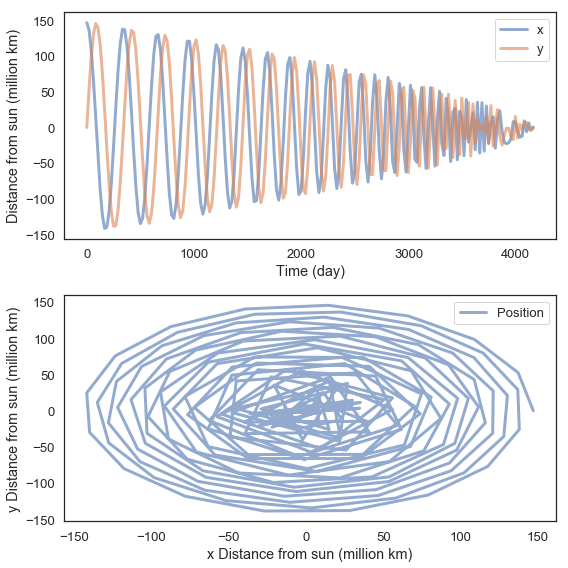

In [15]:
def plot_position(results):
    subplot(2,1,1)
    plot(results.x, label='x')
    plot(results.y, label = 'y')
    decorate(xlabel='Time (day)',
             ylabel='Distance from sun (million km)')
    subplot(2,1,2)
    plot(results.x,results.y, label = 'Position')
    decorate(xlabel='x Distance from sun (million km)',
             ylabel='y Distance from sun (million km)')
    
plot_position(results)

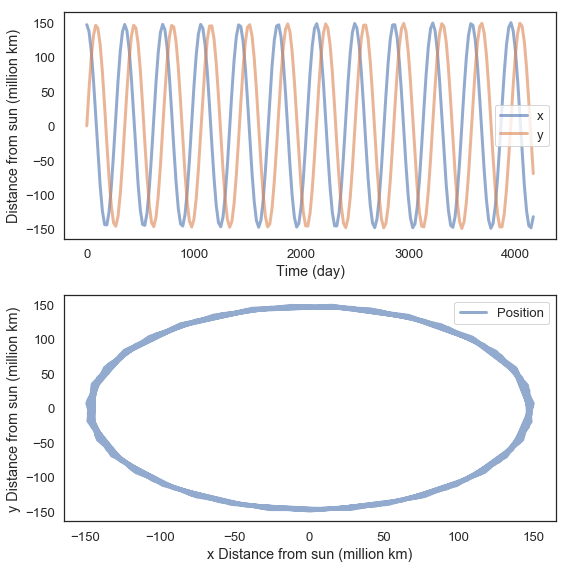

In [16]:
# RK23 stops the Earth from crashing into the Sun and gives us real orbit b/c it makes a smooth curve 

ts = linspace(t_0, t_final, 201)
results, details = run_ode_solver(system, slope_func, events=event_func, t_eval=ts, method = "RK23") #RK23 makes the curve by taking more derivatives and averaging them
#print(results)
results.index /= 60*60*24

results.x /= 1e9
results.y /= 1e9 #converts to millions of km
def plot_position(results):
    subplot(2,1,1)
    plot(results.x, label='x')
    plot(results.y, label = 'y')
    decorate(xlabel='Time (day)',
             ylabel='Distance from sun (million km)')
    subplot(2,1,2)
    plot(results.x,results.y, label = 'Position')
    decorate(xlabel='x Distance from sun (million km)',
             ylabel='y Distance from sun (million km)')
    
plot_position(results)